# Description
*author:* Vina My Pham<br>
*supervisor:* Robin van der Weide<br>
*project:* MSc internship project<br>
<br>
*date:* January 15 - July 26, 2024<br>
*host:* Kind group, Hubrecht Institute<br>
*university:* Bioinformatics, Wageningen University & Research<br>

---

Notebook to merge masks in Z-direction.

> Masks are merged using Non Maximal Suppression with column of choice.

---
**Input**<br>
`overlap_range<neighbor_range>_<sample_name>.csv`

columns:

        0. main_mask_id: ID of the main mask.
        1. main_plane_id: Plane index of the main mask.
        2. main_mask_size: Number of pixels in the main mask.
        3. overlap_mask_id: ID of the overlapping mask.
        4. overlap_plane_id: Plane index of the overlapping mask.
        5. overlap_mask_size: Number of pixels in the overlapping mask.
        6. intersection_size: Number of pixels in the intersection of
            the main and overlapping masks.
        7. union_size: Number of pixels in the union of the main and
            overlapping masks.
        8. ratio_overlap_in_main: Ratio of overlapping mask size to main
            mask size.
        9. jaccard_index: Jaccard index calculated between the main and
            overlapping masks.
        10. dice_coefficient: Dice coefficient calculated between the
            main and overlapping masks.
---
**Output**

-


# Notebook initialisation

## imports

In [180]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

from datetime import datetime
import copy
import os
import json

import numpy as np
import pandas as pd
from IPython.display import display

import skimage.io
import cv2
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

#from cellpose.utils import outlines_list()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## custom functions

### data storage

In [ ]:
#@markdown [classes]
class Stack:
    """A class representing a 3D stack with associated metadata.

    Attributes:
        name (str): The name of the 3D stack
        img_path (str): The file path to the images of 3D stack
        mask_path (str): The file path to the masks of 3D stack
        img_matrix (numpy.ndarray): The image matrix of the 3D stack
        mask_matrix (numpy.ndarray): The mask matrix of the 3D stack
        nplanes (int): The number of planes in the 3D stack
        nchannels (int): The number of channels in the 3D stack
        nmasks (int): The number of masks in the 3D stack
    Notes:
        uses modules skimage.io, matplotlib.pyplot, copy
    """
    def __init__(self, name, img_path, mask_path):
        self.name = name
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_matrix = None
        self.mask_matrix = None
        self.nplanes = None
        self.nchannels = None
        self.nmasks = None

        self.load_data()

    def load_data(self):
        """Load the stack image and masks from the input paths"""
        img_matrix = skimage.io.imread(self.img_path)
        mask_matrix = skimage.io.imread(self.mask_path)

        #check if n planes, x, y are the same
        if img_matrix.shape[:-1] != mask_matrix.shape:
            raise IOError("Dimensions of provided stack " +
                          f"{img_matrix.shape[:-1]} does not correspond " +
                          f"with provided masks {mask_matrix.shape}.")

        self.img_matrix = img_matrix
        self.mask_matrix = mask_matrix

        self.nplanes = self.img_matrix.shape[0]
        self.nchannels = self.img_matrix.shape[-1]
        self.nmasks = len(self.mask_ids())

    def mask_ids(self, iplane = None):
        """

        Returns:
            if iplane=False: all mask ids in the entire stack are returned
            if iplane=int: mask ids present in that plane are returned
        """
        if isinstance(iplane, int):
            mask_ids = list(np.unique(self.mask_matrix[iplane,:,:]))
            mask_ids.remove(0)

        else:
            mask_ids = list(np.unique(np.concatenate([self.mask_ids(i) for i in range(self.nplanes)])))

        return mask_ids

    def plot(self, iplane, mask_id=False, channel=1, plot_outlines=True, outline_color='r', figsize=(10,10), save=False):
        """
        mask_id (False, or int): if False or 0, all masks will be plotted. Else a specific mask under that id will be plotted.
        """
        fig = plt.figure(figsize=figsize)
        plt.imshow(self.img_matrix[iplane,:,:,channel], cmap=plt.cm.gray)
        plt.title(f"plane {iplane}" +
                 (f" (mask {mask_id})" if mask_id else ""))
        plt.axis("off")

        if plot_outlines:
            mask = copy.deepcopy(self.mask_matrix[iplane, :, :])

            if mask_id: #only plot specified mask
                if mask_id not in mask:
                    raise ValueError(f"No mask with mask_id={mask_id} present")

                mask[~np.isin(mask,[mask_id])] = 0

            for o in outlines_list(mask):
                plt.plot(o[:,0], o[:,1], color=outline_color)

        if save: plt.savefig(save)

        plt.show();

        return fig

### main

In [196]:
def extrapolate_using_intersection(stack_data, merge_df, verbose=False):
    """Extrapolates mask data based on intersection info in merge_df.

    Args:
        stack_data (object): Stack data containing mask info.
        merge_df (pd.DataFrame): DataFrame with intersection data.
        verbose (bool): If True, prints progress. Default: False.

    Returns:
        np.ndarray - extrapolated mask data.

    """
    if verbose: print(f"{datetime.now()}\tStarted extrapolation")
    for idx, main_mask_id, main_plane_id, overlap_mask_id, overlap_plane_id, \
        _, gap_iplanes in merge_df.itertuples(index=True):

        if verbose: print(f"\r{datetime.now()}"+
                          f"\t{(idx+1)/(merge_df.shape[0]+1)*100:.2f}%"+
                          f"\tProcessing row {idx} / {merge_df.shape[0]}",
                          end="", flush=True)

        mask_matrix = copy.deepcopy(stack_data.mask_matrix)

        #get main pixels
        main_px = get_mask_px_coords(mask_matrix[main_plane_id, :, :],
                                     main_mask_id)

        #get overlap pixels
        overlap_px = get_mask_px_coords(mask_matrix[overlap_plane_id, :, :],
                                        overlap_mask_id)

        #get intersection
        intersection_px, _, _ = calculate_jaccard(main_px, overlap_px)

        # extrapolate
        for gap_iplane in gap_iplanes:
            for x_coord, y_coord in intersection_px:
                mask_matrix[gap_iplane, x_coord, y_coord] = main_mask_id

    if verbose: print(f"\n{datetime.now()}\tFinished extrapolation")
    return mask_matrix

def rename_matrix(mask_matrix, connected_components, verbose=False):
    if verbose: print(f"{datetime.now()}\tStarted renaming labels")

    merged_label_matrix = np.copy(mask_matrix)

    for idx, component in enumerate(connected_components, 1):
        first_id = min(component)

        if verbose: print(f'\r{datetime.now()}\t{idx}/{len(connected_components)}\tnew id: {first_id}, old ids: {component}', end="", flush=True)

        merged_label_matrix[np.isin(merged_label_matrix, list(component))] = first_id

    if verbose: print(f"\n{datetime.now()}\tFinished renaming labels")
    return merged_label_matrix

In [ ]:
#utils
def get_mask_px_coords(mask_matrix, mask_id):
    """Get pixel coordinates with specified mask ID in a 2D/3D matrix

    Args:
        mask_matrix (numpy.ndarray): mask matrix of one plane or a full stack
            2D shape: nY x nX
            3D shape: nPlanes x nY x nX
        mask_id (int): ID of the mask to retrieve pixel coordinates.

    Returns:
        numpy.ndarray: Array of pixel coordinates where the mask is present
            nested arrays of 2 elements (or 3 if 3D) - 2D: (Y, X)
                                                       3D: (plane id, Y, X)
    """
    mask = copy.deepcopy(mask_matrix)
    mask[~np.isin(mask,[mask_id])] = 0
    return np.transpose(np.nonzero(mask))

def calculate_jaccard(reference_list, compare_list):
    """Calculate Jaccard index between two sets of coordinates.

    Args:
        reference_list (list): np.array of arrays - coordinates for reference
        compare_list (list): np.array of arrays - coordinates for comparison

    Returns:
        0. list of tuples: Tuples both lists have in common (intersection)
        1. list of tuples: All unique tuples in both lists (union)
        2. list of floats: Jaccard index (intersection/union)
    """
    reference_tuples = list(map(tuple, reference_list))
    compare_tuples = list(map(tuple, compare_list))
    intersection = set(reference_tuples).intersection(set(compare_tuples))
    union = set(reference_tuples).union(set(compare_tuples))
    jaccard = len(intersection) / len(union)
    return intersection, union, jaccard

#io
def write_json(parameters: dict,
               save_dir: str,
               output_name: str,
               overwrite=False,
               verbose=True) -> str:
    """Write settings to a JSON file

    Args:
        parameters (dict): Settings to be written to the JSON file
        save_dir (str): The directory path where the JSON file will be saved
        overwrite (bool, optional): Overwrite if file exists. Default: False
        verbose (bool, optional): Print verbose. Default: True

    Returns:
        str: The absolute path of the generated JSON file

    Raises:
        FileExistsError: If a file in `save_dir` already
                         exists with `output_name` and `overwrite` is set to False
    """
    if os.path.exists(save_dir) == False:
      os.makedirs(save_dir)

    json_path = os.path.join(save_dir, output_name)

    if os.path.exists(json_path) and not overwrite:
        raise FileExistsError(f"File '{json_path}' exists and `overwrite` has" +
                              f" been set to {overwrite}")

    with open(json_path, 'w') as outfile_obj:
        json.dump(parameters, outfile_obj, indent=4)

    if verbose:
        print(f"All settings written to {json_path}")

    return json_path

## cellpose

In [ ]:
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>4:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px

# Optional input data (for visualisation)

**User input**
- `stack_name`
- `img stack path` (img shape: nPLanes x nY x nX x nChannels)
- `matrix stack path` (mask shape: nPLanes x nY x nX)
- `overlap_range<neighbor_range:4>_<name:SPE_20230327_D25>.csv`
> *Output from notebook `04_find_overlapping_masks_in_Z.ipynb`.*




Object created (`stack_data`).
name:	SPE_20240216_D35
number of planes:	28
number of channels:	3
number of masks:	942

Preview: slice 14, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


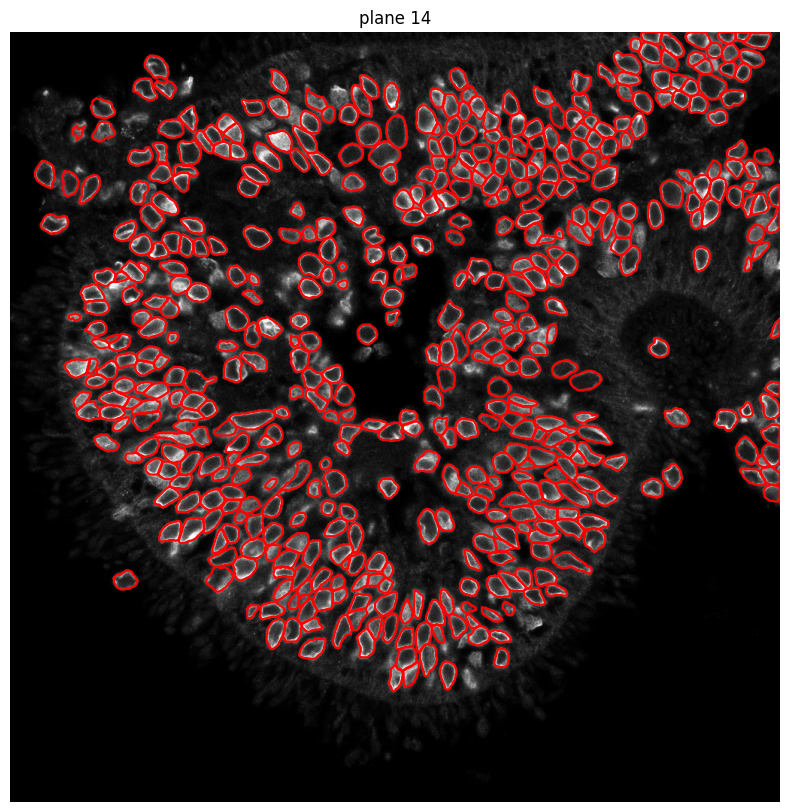

,main_mask_id,main_plane_id,main_mask_size,overlap_mask_id,overlap_plane_id,overlap_mask_size,intersection_size,union_size,ratio_overlap_in_main,ratio_main_in_overlap,jaccard_index,dice_coefficient
0,2,10,292,508,11,643,246,689,0.842466,0.382582,0.357039,0.526203
1,3,12,244,816,16,409,159,494,0.651639,0.388753,0.321862,0.486983
2,5,13,290,599,15,664,3,951,0.010345,0.004518,0.003155,0.006289
3,6,11,326,185,12,633,1,958,0.003067,0.001580,0.001044,0.002086
4,6,11,326,254,12,696,10,1012,0.030675,0.014368,0.009881,0.019569
...,...,...,...,...,...,...,...,...,...,...,...,...
1080,937,24,134,852,20,557,47,644,0.350746,0.084381,0.072981,0.136035
1081,939,25,264,533,21,564,78,750,0.295455,0.138298,0.104000,0.188406
1082,939,25,264,870,21,604,1,867,0.003788,0.001656,0.001153,0.002304
1083,940,25,725,782,21,854,178,1401,0.245517,0.208431,0.127052,0.225459


In [227]:
stack_name = "SPE_20240216_D35" #@param {type:"string"}
img_stack_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20240216_D35.tif" #@param {type:"string"}
mask_stack_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20240216_D35/anisotropy-0.77/3D_masks_mode-stitched2dmasks.tiff" #@param {type:"string"}

stack_data = Stack(stack_name, img_stack_path, mask_stack_path)
print("Object created (`stack_data`)." +
      f"\nname:\t{stack_data.name}" +
      f"\nnumber of planes:\t{stack_data.nplanes}" +
      f"\nnumber of channels:\t{stack_data.nchannels}" +
      f"\nnumber of masks:\t{stack_data.nmasks}")

#show middle slice
iplane=round(stack_data.nplanes/2)
print(f"\nPreview: slice {iplane}, including outlines")
_ = stack_data.plot(iplane, channel=1)
plt.show();

#load overlap_df
overlap_df_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x_merge_fragmented_cellpose3D/overlap_range4_SPE_20240216_D35.csv" #@param {type:"string"}
overlap_df = pd.read_csv(overlap_df_path)
display(overlap_df)

## Init

### add column that specifies the neighbour identity (e.g. +2, or -3)

In [228]:
overlap_df['neighbor_id'] = overlap_df['main_plane_id'] - overlap_df['overlap_plane_id']

overlap_df = overlap_df[['main_mask_id', 'main_plane_id', 'main_mask_size',
                        'overlap_mask_id', 'overlap_plane_id', 'neighbor_id',
                        'overlap_mask_size', 'intersection_size', 'union_size',
                        'ratio_overlap_in_main', 'ratio_main_in_overlap',
                        'jaccard_index', 'dice_coefficient']]
display(overlap_df)

,main_mask_id,main_plane_id,main_mask_size,overlap_mask_id,overlap_plane_id,neighbor_id,overlap_mask_size,intersection_size,union_size,ratio_overlap_in_main,ratio_main_in_overlap,jaccard_index,dice_coefficient
0,2,10,292,508,11,-1,643,246,689,0.842466,0.382582,0.357039,0.526203
1,3,12,244,816,16,-4,409,159,494,0.651639,0.388753,0.321862,0.486983
2,5,13,290,599,15,-2,664,3,951,0.010345,0.004518,0.003155,0.006289
3,6,11,326,185,12,-1,633,1,958,0.003067,0.001580,0.001044,0.002086
4,6,11,326,254,12,-1,696,10,1012,0.030675,0.014368,0.009881,0.019569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,937,24,134,852,20,4,557,47,644,0.350746,0.084381,0.072981,0.136035
1081,939,25,264,533,21,4,564,78,750,0.295455,0.138298,0.104000,0.188406
1082,939,25,264,870,21,4,604,1,867,0.003788,0.001656,0.001153,0.002304
1083,940,25,725,782,21,4,854,178,1401,0.245517,0.208431,0.127052,0.225459


### Plot the metrics based on neighbor_id

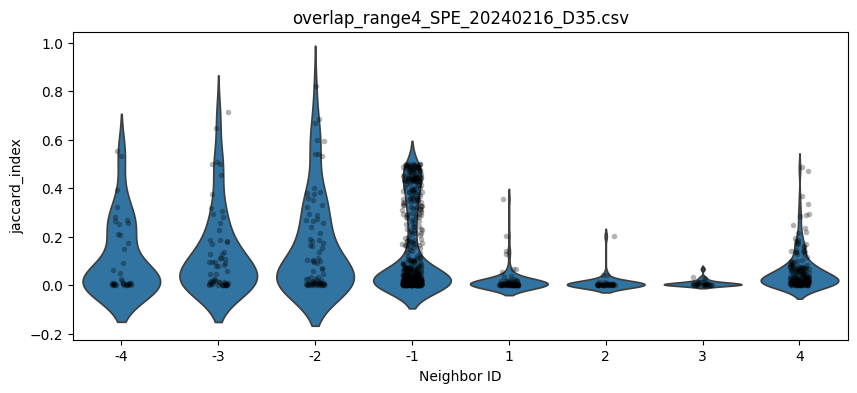

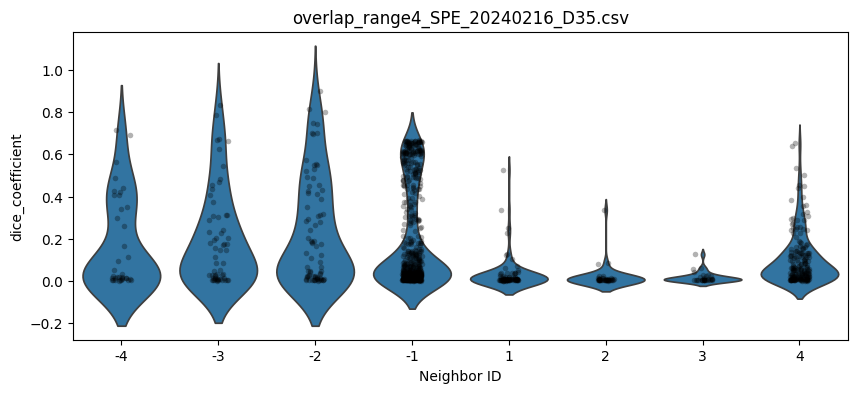

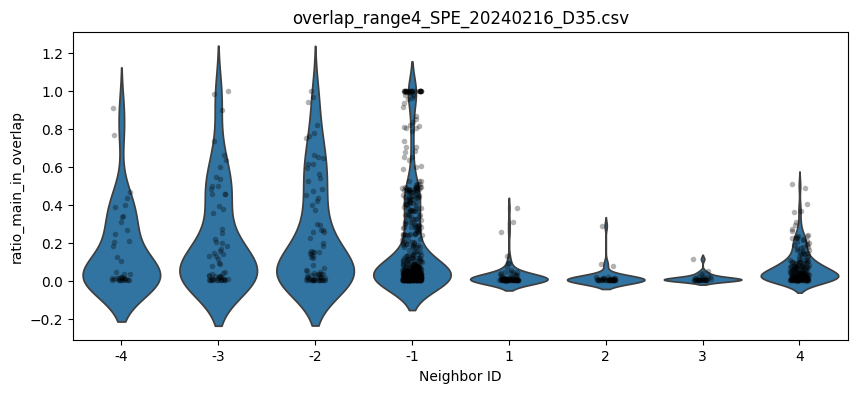

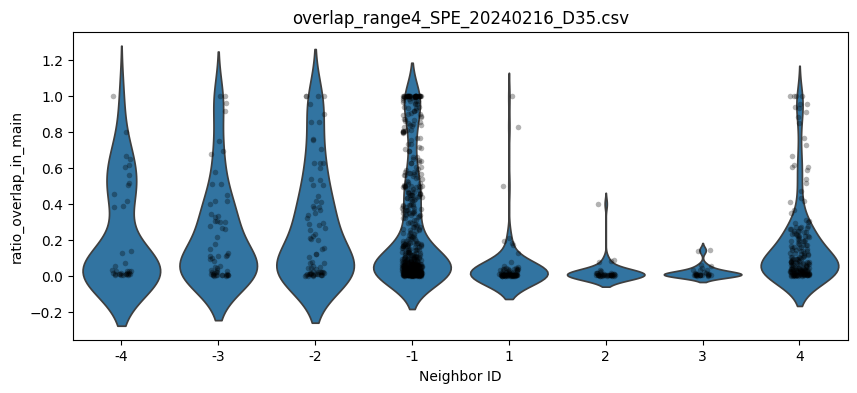

In [229]:
for column in ['jaccard_index', 'dice_coefficient', 'ratio_main_in_overlap', 'ratio_overlap_in_main']:
    plt.figure(figsize=(10, 4))
    sns.violinplot(x='neighbor_id', y=column, data=overlap_df,
                density_norm='width', inner=None, alpha=1)
    sns.stripplot(x='neighbor_id', y=column, data=overlap_df,
                color='black', size=4, jitter=True, alpha=0.3)

    plt.xlabel('Neighbor ID')
    plt.ylabel(column)
    plt.title(overlap_df_path.split('/')[-1])

    plt.savefig(f"{stack_name}_distribution_{column}")
    plt.show()

## Pre-processing of the df
- option to remove rows of overlap with direct neighbors (e.g. `overlap_mask_id` of which abs(`neighbor_id`) = 1

> Enable this option if you want to merge fragmented segmentations

In [216]:
overlap_df = overlap_df[~overlap_df['neighbor_id'].isin([1, -1])]
display(overlap_df)

,main_mask_id,main_plane_id,main_mask_size,overlap_mask_id,overlap_plane_id,neighbor_id,overlap_mask_size,intersection_size,union_size,ratio_overlap_in_main,ratio_main_in_overlap,jaccard_index,dice_coefficient
5,4,59,299,637,61,-2,346,295,350,0.986622,0.852601,0.842857,0.914729
9,6,51,308,573,53,-2,256,255,309,0.827922,0.996094,0.825243,0.904255
12,8,52,593,582,54,-2,448,39,1002,0.065767,0.087054,0.038922,0.074928
13,8,52,593,583,54,-2,514,511,596,0.861720,0.994163,0.857383,0.923216
14,9,75,324,771,77,-2,301,283,342,0.873457,0.940199,0.827485,0.905600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,846,88,438,315,84,4,641,4,1075,0.009132,0.006240,0.003721,0.007414
1172,855,89,795,356,85,4,744,30,1509,0.037736,0.040323,0.019881,0.038986
1173,863,89,689,169,86,3,390,1,1078,0.001451,0.002564,0.000928,0.001854
1174,868,90,650,314,86,4,550,36,1164,0.055385,0.065455,0.030928,0.060000


# Merge based on thresholds

**Merging fragmented 3D segmentations**<br>
Recommended: use the same overlap_thr as done with Cellpose3D.

<br>

**Merging 2D masks into 3D masks**<br>
Recommended: use `ratio_main_in_overlap`

> By merging based on jaccard index, overlapping foci that have drastically different sizes are ignored, e.g.

| main_mask_id | main_plane_id | main_mask_size | overlap_mask_id | overlap_plane_id | overlap_mask_size | intersection_size | union_size | ratio_overlap_in_main | ratio_main_in_overlap | jaccard_index | dice_coefficient |
|--------------|---------------|----------------|-----------------|------------------|-------------------|-------------------|------------|-----------------------|-----------------------|---------------|------------------|
| 2.0          | 0             | 177            | 215.0           | 1                | 31                | 25                | 183        | 0.141243              | 0.806452              | 0.136612      | 0.240385         |

> Here, the jaccard index is incredibly low, despite mask 2 almost entirely encompassing mask 215 (80%).



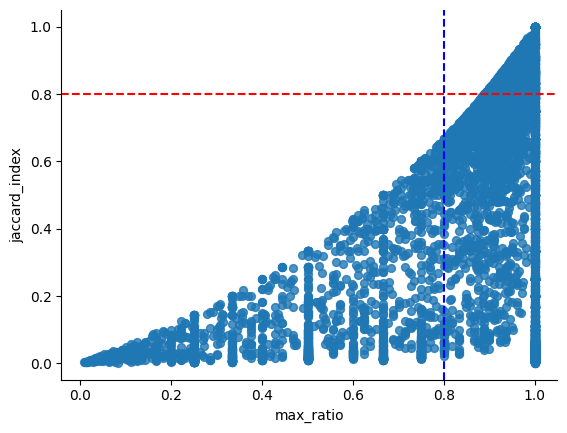

In [ ]:
#@markdown [plot: max(overlap ratio) vs jaccard]<br>
#@markdown This plot visualises how the maximum ratio overlap between two masks is not entirely captured by the JI.<br>
#@markdown For high max( overlap ratio) the majority has low JI<br>
#@markdown If we were to filter on minimum `jaccard`, we would merge the masks above the red line.<br>
#@markdown If we were to filter on minimum `max(ratio)`, we would merge the masks to the right of the blue line.
subdf = copy.deepcopy(overlap_df)
subdf['max_ratio'] = overlap_df[['ratio_overlap_in_main', 'ratio_main_in_overlap']].max(axis=1)
subdf = subdf[['ratio_overlap_in_main', 'ratio_main_in_overlap','max_ratio','jaccard_index']]
subdf.plot(kind='scatter', x='max_ratio', y='jaccard_index', s=32, alpha=.8)

# Visualise what would be detected if we filtered on jaccard
plt.axhline(y=0.8, color='red', linestyle='--')

# Visualise what would be detected if we filtered on max(ratio)
plt.axvline(x=0.8, color='blue', linestyle='--')

plt.gca().spines[['top', 'right',]].set_visible(False)


#Thresholding

**Input**
- `min_overlap_threshold` (float): minimum value
- `cols` (list of str): column names to use as filters

> currently the same thr value for all selected cols.

- `retain_max`: keep only the row of the maximum `col` if there are multiple rows with the same `main_mask_id`.
> currently only works if len(cols) = 1

**Output**
- `filtered_overlap_df`: the overlap df filtered based on the input settings.

In [230]:
#options
min_overlap_threshold = 0.5 #@param
cols = ['jaccard_index'] #@param
retain_max = True #@param {type:"boolean"}

if len(cols) > 1 and retain_max:
    raise ValueError("retain_max only works if only one col is selected for filtering.")

#filter on the colums
filtered_overlap_df = overlap_df[(overlap_df[cols] >= min_overlap_threshold).any(axis=1)]

#keep highest hit
if retain_max:
    idx = filtered_overlap_df.groupby('main_mask_id')[cols[0]].idxmax()
    filtered_overlap_df = filtered_overlap_df.loc[idx]

display(filtered_overlap_df)

,main_mask_id,main_plane_id,main_mask_size,overlap_mask_id,overlap_plane_id,neighbor_id,overlap_mask_size,intersection_size,union_size,ratio_overlap_in_main,ratio_main_in_overlap,jaccard_index,dice_coefficient
10,9,15,392,864,18,-3,303,273,422,0.696429,0.900990,0.646919,0.785612
27,21,0,443,197,3,-3,578,425,596,0.959368,0.735294,0.713087,0.832517
38,27,0,243,148,2,-2,376,232,387,0.954733,0.617021,0.599483,0.749596
150,101,1,332,181,3,-2,613,332,613,1.000000,0.541599,0.541599,0.702646
158,110,1,153,243,4,-3,305,153,305,1.000000,0.501639,0.501639,0.668122
344,260,5,208,474,7,-2,236,178,266,0.855769,0.754237,0.669173,0.801802
375,290,17,228,915,21,-4,141,128,241,0.561404,0.907801,0.531120,0.693767
383,295,17,212,918,21,-4,183,141,254,0.665094,0.770492,0.555118,0.713924
415,324,13,681,793,15,-2,548,428,801,0.628488,0.781022,0.534332,0.696501
440,348,15,338,834,17,-2,397,258,477,0.763314,0.649874,0.540881,0.702041


## Overview of the overlapping mask networks that pass the filtering
**Description**

If merging 3D segmentations: the number indicates how many main 3D merges happened. Example:
| Number of mask networks:  3 |
---------------------------------
{898, 926, 5, 878}
{8, 434, 453}
{9, 555}

means that the masks (898, 926, 5, 878) will merge together into one, and the same goes for (8, 434, 453) and (9, 555). In total, there are 3 main merge events.

If merging 2D segmentations: the number represents the number of 3D masks that could be created based on the settings.


In [231]:
print_detailed = True #@param {type:"boolean"}
n_print_lines = 10 # @param {type:"number"}
merge_df = filtered_overlap_df[['main_mask_id', 'main_plane_id', 'overlap_mask_id', 'overlap_plane_id',]+cols]
G = nx.from_pandas_edgelist(merge_df, source='main_mask_id', target='overlap_mask_id')

# Find connected components
connected_components = list(nx.connected_components(G))

print("Number of overall mask networks: ", len(connected_components))

if print_detailed:
    print(f'\nFirst {n_print_lines} networks:')
    for component in connected_components[:n_print_lines+1]:
        print(f"\t{component}")

#add gap planes
merge_df = merge_df.copy() #so that the SettingWithCopyWarning isnt shown.
gap_iplanes_list = []

for _, main_plane_id, _, overlap_plane_id, _ in merge_df.itertuples(index=False):
    #determine direction
    if main_plane_id - overlap_plane_id < 0:
        gap_iplanes = range(main_plane_id+1, overlap_plane_id)
    else:
        gap_iplanes = range(overlap_plane_id+1, main_plane_id)
    gap_iplanes_list.append(gap_iplanes)

merge_df.loc[:, 'gap_iplanes'] = gap_iplanes_list
merge_df.reset_index(drop=True, inplace=True)
display(merge_df)

Number of overall mask networks:  14

First 10 networks:
	{864, 9}
	{197, 21}
	{27, 148}
	{101, 181}
	{243, 110}
	{474, 260}
	{290, 915}
	{918, 295}
	{793, 324}
	{834, 348}
	{930, 494}


,main_mask_id,main_plane_id,overlap_mask_id,overlap_plane_id,jaccard_index,gap_iplanes
0,9,15,864,18,0.646919,"(16, 17)"
1,21,0,197,3,0.713087,"(1, 2)"
2,27,0,148,2,0.599483,(1)
3,101,1,181,3,0.541599,(2)
4,110,1,243,4,0.501639,"(2, 3)"
5,260,5,474,7,0.669173,(6)
6,290,17,915,21,0.531120,"(18, 19, 20)"
7,295,17,918,21,0.555118,"(18, 19, 20)"
8,324,13,793,15,0.534332,(14)
9,348,15,834,17,0.540881,(16)


# Inspection
- for each merge event, show plane_id for each merge event id

# For stitching 3D masks: extrapolate using the intersection

In [232]:
extrapolated_matrix = extrapolate_using_intersection(stack_data, merge_df, verbose=True)

2024-04-23 13:47:13.638724	Started extrapolation
2024-04-23 13:47:14.389750	93.33%	Processing row 13 / 14
2024-04-23 13:47:14.451320	Finished extrapolation


## For stitching 2D masks: rename the masks in the label matrix to the first entry of the component (25s for 174)

In [233]:
merged_label_matrix = rename_matrix(extrapolated_matrix, connected_components, verbose=True)

2024-04-23 13:47:32.169470	Started renaming labels
2024-04-23 13:47:33.531486	14/14	new id: 836, old ids: {873, 836}
2024-04-23 13:47:33.623624	Finished renaming labels


# Export

In [234]:
#https://stackoverflow.com/questions/55228993/save-3d-array-into-a-stack-of-2d-images-in-python
outdir = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x_merge_fragmented_cellpose3D/" #@param {type:"string"}
outfile_name = f"{stack_name}_stitched.tiff" #@param {type:"raw"}
tifffile.imwrite(outdir+outfile_name, merged_label_matrix, bigtiff=True)
print(f"Merged 3D labels have been saved as {outfile_name}")

Merged 3D labels have been saved as SPE_20240216_D35_stitched.tiff


# Write settings to JSON

In [235]:
parameters_dict = {
    "stack_name": stack_name,
    "img_stack_path": img_stack_path,
    "mask_stack_path": mask_stack_path,
    "overlap_df_path": overlap_df_path,
    "min_overlap_threshold": min_overlap_threshold,
    "cols": cols,
    "retain_max": retain_max,
    "connected_components": str(connected_components)
}


In [236]:
write_json(parameters_dict,
           outdir,
           f"{stack_name}_params.JSON",
           overwrite=True,
           verbose=True)

All settings written to /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x_merge_fragmented_cellpose3D/SPE_20240216_D35_params.JSON


'/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04x_merge_fragmented_cellpose3D/SPE_20240216_D35_params.JSON'